## Word2Vec using Tensorflow

In [1]:
# Import Dependencies
import os
import math
import collections
from collections import Counter
import errno
import random
import zipfile
import numpy as np
from six.moves import urllib, xrange
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the Data
def fetch_words(url, words_data):
    # Make Directory if it does not exists
    os.makedirs(words_data, exist_ok=True)
    
    # Path to Zip File
    file_path = os.path.join(words_data, 'words.zip')
    
    # If zip file is not present, download it
    if not os.path.exists(file_path):
        print('Downloading Data ...')
        urllib.request.urlretrieve(url,file_path)
        
    # Get data from Zip File
    with zipfile.ZipFile(file_path) as f:
        print('Loading Data from Zip File ...')
        data = f.read(f.namelist()[0])
    
    # Return a list of all words in data source
    return data.decode('ascii').split()

In [3]:
# Load all Words
data_url = 'http://mattmahoney.net/dc/text8.zip'
saved_data = './word2vec_data/words/'
words = fetch_words(url=data_url, words_data=saved_data)

Loading Data from Zip File ...


In [4]:
# Print Sample Words
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [5]:
# Length of Word list
len(words)

17005207

In [6]:
# Print a sentence using Words
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [7]:
# Word Count
def word_count(vocab_size):
    # Grab most common words (with count)
    vocab = [] + Counter(words).most_common(vocab_size)
    # Numpy Array of Most Common Words (without count)
    vocab = np.array([w for w, _ in vocab])
    # Create Dictionary
    dictionary = {word:code for code,word in enumerate(vocab)}
    # Create Data
    data = np.array([dictionary.get(word,0) for word in words])
    return data, vocab

In [8]:
# Test the Function
data, vocabulary = word_count(vocab_size=50000)

In [9]:
data[:10]

array([5236, 3081,   11,    5,  194,    1, 3133,   45,   58,  155])

In [10]:
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [11]:
# Shape of Data
data.shape

(17005207,)

In [12]:
vocabulary[:10]

array(['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two'],
      dtype='<U28')

In [13]:
vocabulary.shape

(50000,)

In [14]:
# Word at Index
words[1000]

'american'

In [15]:
# Corresponding Number at same Index
data[1000]

63

In [16]:
# Function to load data in Batches
def generate_batches(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

### Create Word2Vec Model

In [17]:
# Constants
data_index = 0

# Batch Size
batch_size = 128

# Embedding Size: How many dimensions will the embedding vector have
embedding_size = 150

# Skip Window: How many words to consider to left and right 
skip_window = 1

# Number Skips: How many times to reuse input to generate a variable
num_skips = 2

# Valid Size: Random set of words to evaluate similarity on
valid_size = 16

# Valid Window: Pick samples from head of distribution 
valid_window = 100

# Number of words with low numeric ID
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of -ve examples in sample
num_sampled = 64

# Number of Training Steps
num_steps = 100000

# Learning Rate
lr = 0.01

# Vocabulary Size
vocabulary_size = 50000

In [18]:
# Define Placeholders
tf.reset_default_graph()

# Training Inputs [Word ID's]: shape = None [i.e. defined by batch size]
train_inputs = tf.placeholder(tf.int32, shape=[None])

# Training Labels
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])

# Valid Examples
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [19]:
# Variables
# Randomly choose values from -1 to 1
initial_embedding = tf.random_uniform([vocabulary_size, embedding_size],-1.0,1.0)
embeddings = tf.Variable(initial_embedding)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [20]:
# Loss Function : NCE Loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))
nce_bias = tf.Variable(tf.zeros([vocabulary_size]))

In [21]:
# Loss Function
#loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights,nce_bias, train_labels, embed, num_sampled, vocabulary_size))
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_bias, train_labels, embed, num_sampled, vocabulary_size))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
trainer = optimizer.minimize(loss)

In [22]:
# Minibatch Cosine Similarity
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
# Create Normalized Embeddings
normalized_embeddings = embeddings / norm

valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
# Get Cosine Similarity
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [23]:
init = tf.global_variables_initializer()

In [24]:
# Run the Model
with tf.Session() as sess:
    sess.run(init)
    
    # Initialize Average Loss
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batches(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        empty , loss_val = sess.run([trainer,loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss/1000
            print('Average Loss at Step {0} is : {1}'.format(step, average_loss))
            average_loss = 0
        
        final_embeddings = normalized_embeddings.eval()

Average Loss at Step 0 is : 261.65594482421875
Average Loss at Step 1000 is : 219.06063451385498
Average Loss at Step 2000 is : 149.97230739212037
Average Loss at Step 3000 is : 112.79199514293671
Average Loss at Step 4000 is : 98.7392550945282
Average Loss at Step 5000 is : 86.6120760846138
Average Loss at Step 6000 is : 82.47701379811764
Average Loss at Step 7000 is : 69.6498720101118
Average Loss at Step 8000 is : 70.94620711952447
Average Loss at Step 9000 is : 65.8582764250189
Average Loss at Step 10000 is : 52.325012790322305
Average Loss at Step 11000 is : 42.54095972451567
Average Loss at Step 12000 is : 44.70946494537592
Average Loss at Step 13000 is : 41.70825965113938
Average Loss at Step 14000 is : 48.719807987205684
Average Loss at Step 15000 is : 45.956849894404414
Average Loss at Step 16000 is : 39.6074327557683
Average Loss at Step 17000 is : 43.271382714420554
Average Loss at Step 18000 is : 41.71040016233921
Average Loss at Step 19000 is : 48.846426277577876
Average L

In [25]:
final_embeddings.shape

(50000, 150)

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [53]:
# Plot only 500 words
plot_only = 200

In [54]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [55]:
labels = [vocabulary[i] for i in range(200)]

In [56]:
low_dim_embed.shape

(200, 2)

In [57]:
# Plot the Word Embeddings
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More Labels than Embeddings..."
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', ha='right',va='bottom')

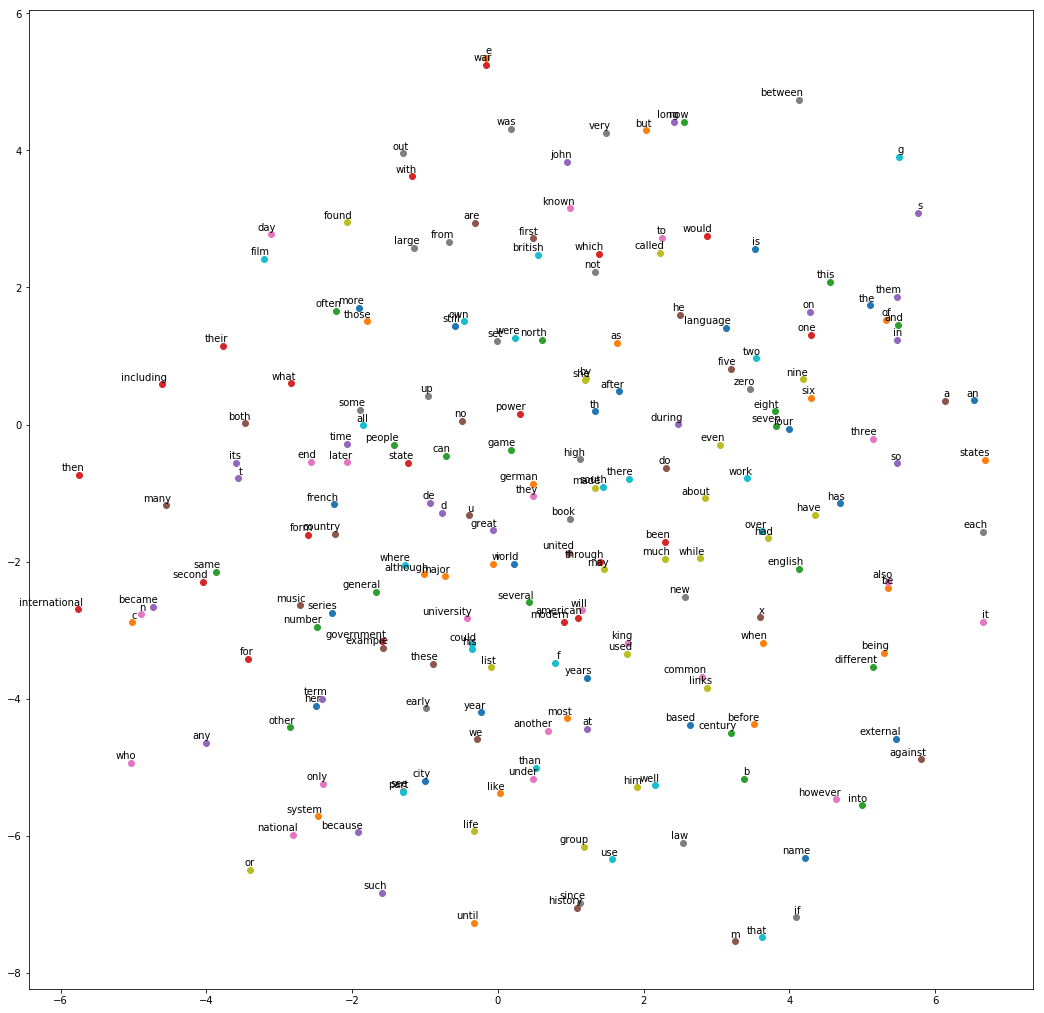

In [58]:
plot_with_labels(low_dim_embed, labels)